## Different imports and setup

In [1]:
# Standard import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
# Machine learning libraries
from tensorflow import keras
import tensorflow as tf

In [3]:
from Tools import Plot
from Tools import Custom_models
from Tools import Helpers

## Set the seeds and extract the testing set

In [4]:
# Set the seed for reproducibility
seed = 6
np.random.seed(seed)
tf.random.set_seed(seed*2)

In [5]:
_, _, _, _, features_test, labels_test = Helpers.Load_and_split_val('Data/tanh_2D.txt', D=2,
                                                                    seed=seed, ratio_test=0.1, ratio_val=0.1)

## Load a model

In [66]:
MSE = []
MAE = []
MaAE = []

for i in range(5):
    model_name = f'Saved_models/2D/Depth_study_K_10/batch_32-depth_10-iter_{i}'
    model = keras.models.load_model(model_name)
    MSE.append(Helpers.MSE(model, features_test, labels_test))
    MAE.append(Helpers.MAE(model, features_test, labels_test))
    MaAE.append(Helpers.MaAE(model, features_test, labels_test))

In [67]:
# Check the min, mean, and max
a = MSE
print(f'Min : {np.min(a):.4e}')
print(f'Mean : {np.mean(a):.4e}')
print(f'Max : {np.max(a):.4e}')

Min : 4.2959e-02
Mean : 5.4459e-02
Max : 6.3829e-02


In [71]:
best = np.argmin(MSE)
best

4

In [80]:
model_name = f'Saved_models/2D/Depth_study_K_10/batch_32-depth_10-iter_{best}'
model = keras.models.load_model(model_name)
history = pd.read_csv(model_name + '.csv')

In [81]:
model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-05>

## Assess the performance of the model on the testing set

In [88]:
mse = Helpers.MSE(model, features_test, labels_test)
mae = Helpers.MAE(model, features_test, labels_test)
maae = Helpers.MaAE(model, features_test, labels_test)
print(f'The MSE is : {mse:.4e}')
print(f'The MAE is : {mae:.4e}')
print(f'The MaAE is : {maae:.4e}')

The MSE is : 7.7401e-06
The MAE is : 1.0660e-03
The MaAE is : 4.2959e-02


## Print the history

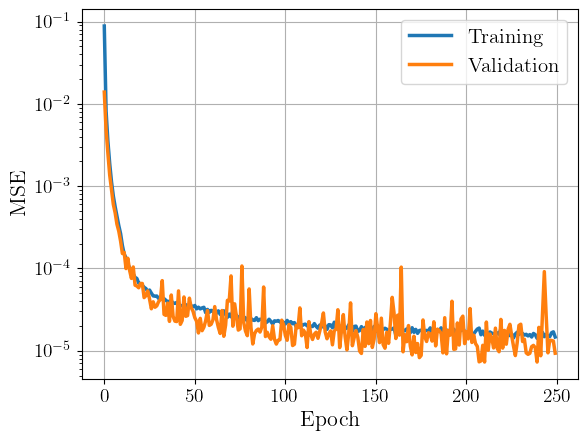

In [83]:
save = False
name = 'Figures/2D/2_layers/best_training_error.pdf'

plt.figure()
plt.plot(history['epoch'], history['loss'])
plt.plot(history['epoch'], history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training', 'Validation'])
plt.yscale('log')
plt.grid()
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Check the result on a grid

In [84]:
x = np.linspace(-1, 1, 1000)
X,Y = np.meshgrid(x, x)

In [85]:
# Creates coordinates vector from the grid
coordinates = np.vstack([X.ravel(), Y.ravel()]).T
pred = model.predict(coordinates).ravel()

# Re-transform the result as a matrix for use in color plot
Z_pred = pred.reshape(len(x), len(x))

# True function
center = [0, 0] 
r = 1/2        
k = 50
Z_true = 1/2*(1 + np.tanh(-k*(np.sqrt((X-center[0])**2 + (Y-center[1])**2) - r)))

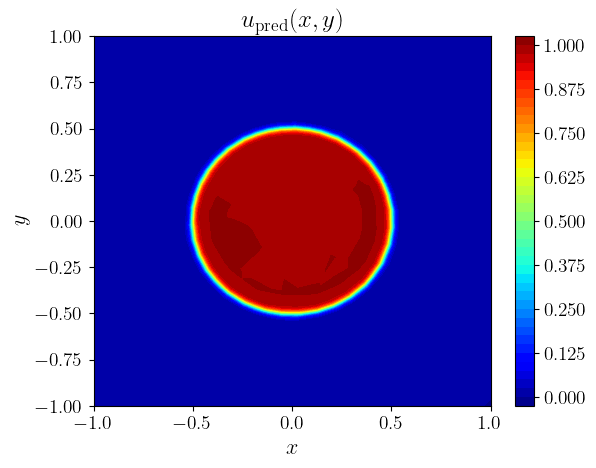

In [115]:
filename = 'Figures/2D/Depth/2_layers_approximation'
save = False

plt.figure()
plt.contourf(X, Y, Z_pred, levels=40, cmap='jet')
plt.title(r'$u_{\text{pred}}(x,y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
if (save):
    plt.savefig(filename, bbox_inches='tight')
plt.show()

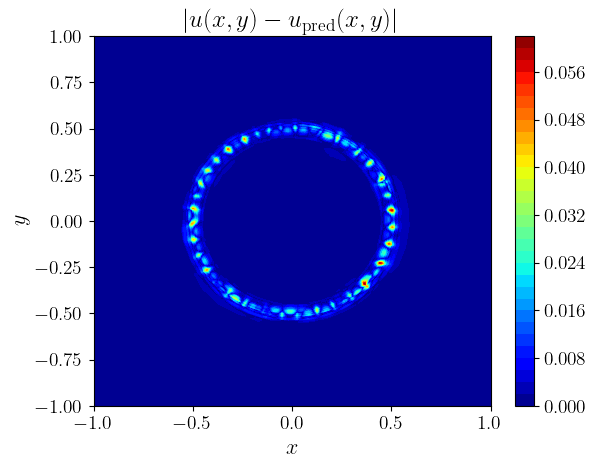

In [116]:
filename = 'Figures/2D/Depth/2_layers_approximation_diff'
save = False

plt.figure()
plt.contourf(X, Y, np.abs(Z_true - Z_pred), levels=40, cmap='jet')
plt.title(r'$|u(x,y) - u_{\text{pred}}(x,y)|$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
if (save):
    plt.savefig(filename, bbox_inches='tight')
plt.show()

## Check the approximation against the radius

In [113]:
# Line y=x from x=y=1/2

x = np.linspace(0, 1, 50000)
coord = np.array([x,-x]).T 

rad = np.linalg.norm(coord - center, ord=2, axis=1)
pred = model.predict(coord).ravel()
y_true = 1/2*(1 + np.tanh(-k*(rad - r)))

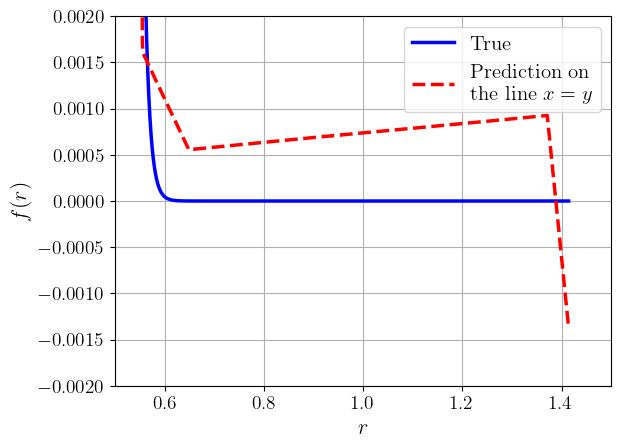

In [114]:
name = 'Figures/2D/2_layers/2_layers_radius_zoom'
save = False

plt.figure()
plt.plot(rad, y_true, 'b-', label='True')
plt.plot(rad, pred, 'r--', label='Prediction on\nthe line $x=y$')
plt.xlabel('$r$')
plt.ylabel('$f(r)$')
plt.legend()
plt.grid()
plt.xlim([0.5, 1.5])
plt.ylim([-0.002, 0.002])
if (save):
    plt.savefig(name, bbox_inches='tight')
plt.show()

## Print a summary of the loaded model

In [92]:
model.sequence.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 10)                30        
_________________________________________________________________
dense2 (Dense)               (None, 10)                110       
_________________________________________________________________
dense3 (Dense)               (None, 10)                110       
_________________________________________________________________
dense4 (Dense)               (None, 10)                110       
_________________________________________________________________
dense5 (Dense)               (None, 10)                110       
_________________________________________________________________
dense6 (Dense)               (None, 10)                110       
_________________________________________________________________
dense7 (Dense)               (None, 10)                1

## Extract layers of the model

In [93]:
layers = [model.sequence.get_layer(name=f'dense{i}') for i in range(1,12)]

## Compute the basis functions created by the model

In [94]:
# Computes the interval on which evaluate the basis functions and the real solution
x = np.linspace(-1, 1, 1000)
X,Y = np.meshgrid(x, x)

# Creates coordinates vector from the grid
coordinates = np.vstack([X.ravel(), Y.ravel()]).T

# True function
center = [0, 0] 
r = 1/2         
k = 50
Z_true = 1/2*(1 + np.tanh(-k*(np.sqrt((X-center[0])**2 + (Y-center[1])**2) - r)))

In [95]:
basis_1 = Helpers.basis_functions_layer_2D(coordinates, layers[0:1])
basis_2 = Helpers.basis_functions_layer_2D(coordinates, layers[0:2])

In [62]:
# Normalization of basis functions and removal of non-active neurons
basis1 = Helpers.normalize_basis_2D(basis_1)
basis2 = Helpers.normalize_basis_2D(basis_2)

## Visualize the basis functions in 2D

/var/folders/r9/sn_m76cx1pngmrvcqmrwbls40000gn/T/ipykernel_15530/261134381.py:12: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, basis[i], levels=0, colors='w')


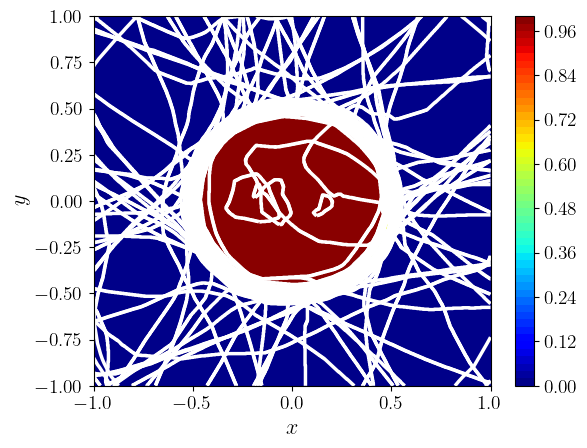

In [65]:
filename = 'Figures/2D/2_layers/basis_function_second_layer.pdf'
save = False

# To visualize only one function each offset values
offset = 1

# To visualize the right layer
basis = basis_2

plt.figure()
for i in range(0, len(basis), offset):
    plt.contour(X, Y, basis[i], levels=0, colors='w')
plt.contourf(X, Y, Z_true, levels=50, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
if (save):
    plt.savefig(filename, bbox_inches='tight')
plt.show()

## Visualize the basis function radially

In [96]:
x = np.linspace(0, 1, 50000)
coord = np.array([x,x]).T 

center = [0,0]
rad = np.linalg.norm(coord - center, ord=2, axis=1)

r = 1/2
k = 50
y_true = 1/2*(1 + np.tanh(-k*(rad - r)))

In [111]:
basis1 = Helpers.basis_functions_radius(coord, layers[0:1])
basis2 = Helpers.basis_functions_radius(coord, layers[0:2])
basis5 = Helpers.basis_functions_radius(coord, layers[0:5])
basis6 = Helpers.basis_functions_radius(coord, layers[0:6])
basis9 = Helpers.basis_functions_radius(coord, layers[0:9])
basis10 = Helpers.basis_functions_radius(coord, layers[0:10])

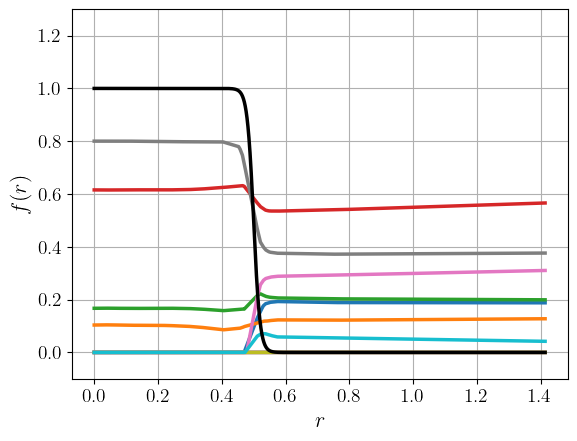

In [112]:
filename = 'Figures/2D/Depth/basis_function_radial_layer9.pdf'
save = False

# To visualize only one function each offset values
offset = 1

# To visualize the right layer
basis = basis9

plt.figure()
for i in range(0, len(basis), offset):
    plt.plot(rad, basis[i,:])
plt.plot(rad, y_true, 'k-')
plt.xlabel('$r$')
plt.ylabel('$f(r)$')
plt.ylim([-0.1, 1.3])
plt.grid()
if save:
    plt.savefig(filename, bbox_inches='tight')
plt.show()